In [1]:
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar10, mnist
from tensorflow.keras import backend as K
import numpy as np

# 데이터셋 로드하기
# (x_train, y_train), (x_test, y_test) = cifar10.load_data()
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# 데이터 전처리하기
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

11490434/11490434 [==============================] - 0s 0us/step


In [2]:
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar10, mnist
from tensorflow.keras import backend as K
import numpy as np

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32').reshape(-1, 28, 28, 1) / 255.
x_test = x_test.astype('float32').reshape(-1, 28, 28, 1) / 255.

data_shape = x_train.shape[1:]

In [3]:
class VAE(keras.Model):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = self.build_encoder()
        self.decoder = self.build_decoder()
        self.z_mean = 0
        self.z_log_var = 0

    def build_encoder(self):

        encoder_inputs = keras.Input(shape=data_shape)

        x = layers.Conv2D(8, 3, activation='relu', strides=1, padding='same')(encoder_inputs)
        x = layers.MaxPooling2D((2,2), padding='same')(x)
        x = layers.Conv2D(16, 3, activation='relu', strides=1, padding='same')(x)
        x = layers.MaxPooling2D((2,2), padding='same')(x)
        x = layers.Conv2D(32, 3, activation='relu', strides=1, padding='same')(x)

        x = layers.Flatten()(x)
        x = layers.Dense(64, activation='relu')(x)
        x = layers.Dense(16, activation='relu')(x)

        # 위의 x를 받아서 평균과 분산 두 갈래로 나뉘어짐
        z_mean = layers.Dense(self.latent_dim, name="z_mean")(x)
        z_log_var = layers.Dense(self.latent_dim, name="z_log_var")(x)
        
        encoder = keras.Model(encoder_inputs, [z_mean, z_log_var], name="encoder")
        return encoder

    def build_decoder(self):

        latent_inputs = keras.Input(shape=(latent_dim,))

        x = layers.Dense(7 * 7 * 16, activation='relu')(latent_inputs)
        x = layers.BatchNormalization()(x)
        x = layers.Reshape((7, 7, 16))(x)
        x = layers.Conv2DTranspose(16, 3, activation='relu', strides=1, padding='same')(x)
        x = layers.UpSampling2D()(x)
        x = layers.Conv2DTranspose(8, 3, activation='relu', strides=1, padding='same')(x)
        x = layers.UpSampling2D()(x)
        x = layers.Conv2DTranspose(4, 3, activation='relu', strides=1, padding='same')(x)
        decoder_outputs = layers.Conv2DTranspose(1, 3, activation='sigmoid', padding='same')(x)

        decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
        return decoder

    def call(self, x):
        self.z_mean, self.z_log_var = self.encoder(x)
        z = self.sampling(self.z_mean, self.z_log_var)
        x_decoded = self.decoder(z)
        return x_decoded
    
    def vae_loss(self, x, x_decoded):
        reconstruction_loss = tf.reduce_sum(tf.reshape(keras.losses.MSE(x, x_decoded), (-1, 28*28)), axis = -1)
        # reconstruction_loss = tf.reduce_mean(keras.losses.binary_crossentropy(x, x_decoded))
        kl_loss = -0.5 * K.sum(1 + self.z_log_var - K.square(self.z_mean) \
                                           - K.exp(self.z_log_var), axis=1)
        # print(reconstruction_loss.shape, kl_loss.shape)
        return K.mean(5*reconstruction_loss + kl_loss)

    def sampling(self, z_mean, z_log_var):
        batch = K.shape(z_mean)[0]
        dim = K.int_shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))

        return z_mean + K.exp(0.5 * z_log_var) * epsilon


In [4]:
# VAE 모델 만들기
latent_dim = 2
vae = VAE(latent_dim)

# 모델 컴파일하기
vae.compile(optimizer='adam', loss=vae.vae_loss) # 사용자가 지정한 loss fn 사용
vae(x_test).shape

TensorShape([10000, 28, 28, 1])

In [5]:
vae.summary()

Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Functional)        [(None, 2),               107412    
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         9297      
                                                                 
Total params: 116,709
Trainable params: 115,141
Non-trainable params: 1,568
_________________________________________________________________


In [6]:
vae.encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 28, 28, 8)    80          ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 14, 14, 8)    0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 14, 14, 16)   1168        ['max_pooling2d[0][0]']          
                                                                                            

In [7]:
vae.decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_2 (Dense)             (None, 784)               2352      
                                                                 
 batch_normalization (BatchN  (None, 784)              3136      
 ormalization)                                                   
                                                                 
 reshape (Reshape)           (None, 7, 7, 16)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 16)         2320      
 nspose)                                                         
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 16)       0   

In [8]:
# 모델 학습하기
vae.fit(x_train, x_train, epochs=20, batch_size=512, validation_split=0.1)

Epoch 1/20
106/106 [==============================] - 9s 20ms/step - loss: 446.8319 - val_loss: 493.7122
Epoch 2/20
106/106 [==============================] - 1s 12ms/step - loss: 233.1943 - val_loss: 301.3550
Epoch 3/20
106/106 [==============================] - 1s 11ms/step - loss: 202.4778 - val_loss: 261.0530
Epoch 4/20
106/106 [==============================] - 1s 12ms/step - loss: 193.2540 - val_loss: 227.9088
Epoch 5/20
106/106 [==============================] - 1s 11ms/step - loss: 187.8380 - val_loss: 203.5057
Epoch 6/20
106/106 [==============================] - 2s 15ms/step - loss: 183.7354 - val_loss: 187.7745
Epoch 7/20
106/106 [==============================] - 1s 13ms/step - loss: 180.6732 - val_loss: 179.4090
Epoch 8/20
106/106 [==============================] - 1s 12ms/step - loss: 177.9575 - val_loss: 176.4200
Epoch 9/20
106/106 [==============================] - 1s 12ms/step - loss: 176.2666 - val_loss: 177.8293
Epoch 10/20
106/106 [==============================] - 

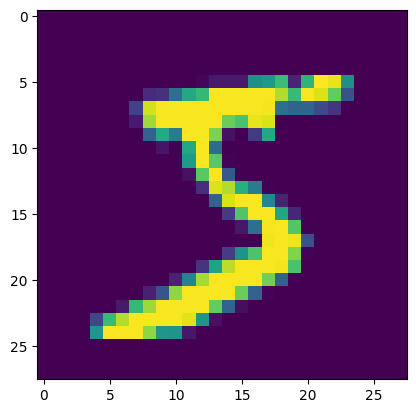

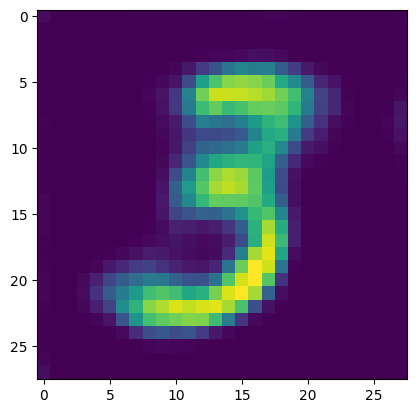

In [12]:
import matplotlib.pyplot as plt
recon = vae(x_train[:1])[0] 

plt.imshow(x_train[0])
plt.show()

plt.imshow(recon)
plt.show()

1/1 [==============================] - 0s 359ms/step


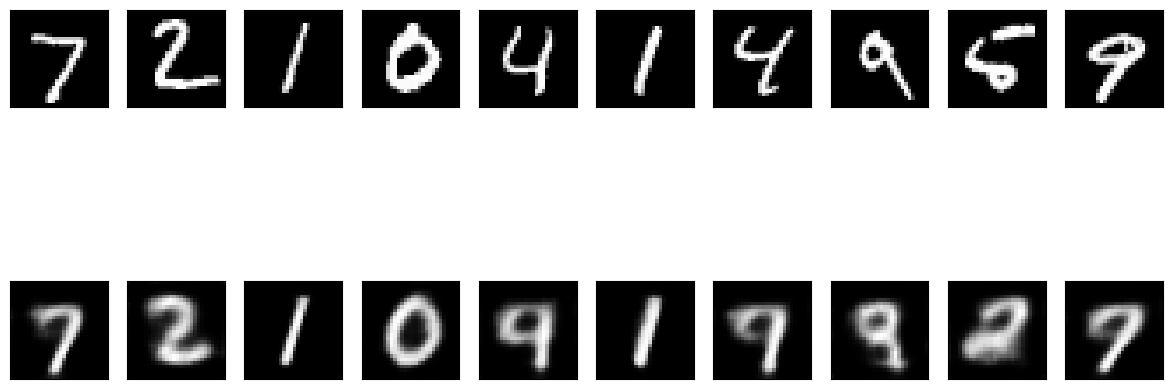

In [13]:
from matplotlib import pyplot as plt
predicted = vae.predict(x_test[:20])

plt.figure(figsize=(30,5))
for i in range(10):
    ax = plt.subplot(3, 20, i + 1)
    plt.imshow(x_test[i].reshape(data_shape), cmap = 'gray')

    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(3, 20, 2*20 +i+ 1)
    plt.imshow(predicted[i].reshape(data_shape), cmap = 'gray')

    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

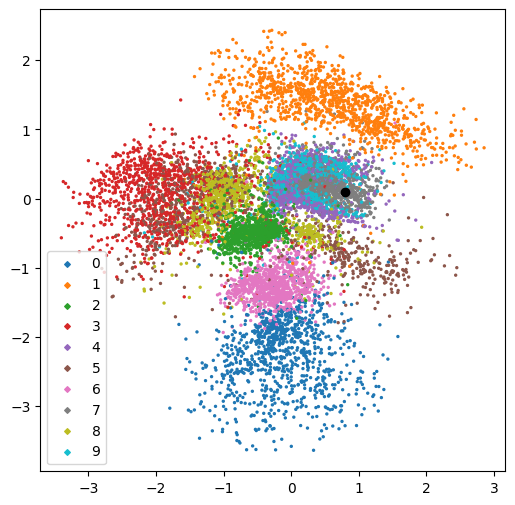

In [15]:
from matplotlib import pyplot as plt

x_encoded, _ = vae.encoder(x_test)
x_encoded = x_encoded.numpy()

plt.figure(figsize=(6, 6))
plt.scatter(x_encoded[:, 0], x_encoded[:, 1], 
            c=[f'C{label}' for label in y_test], 
            s = 2
            )

sample_pt = [0.8, 0.1]
sample_tensor = tf.expand_dims(sample_pt, 0)
plt.plot(sample_pt[0],sample_pt[1], 'o-', c = 'k')

for i in range(10):
    plt.scatter([], [], c=f'C{i}', label=str(i), s = 8, marker = 'D')

plt.legend()
plt.show()

In [16]:
import plotly.graph_objects as go
import plotly.express as px
fig = go.Figure()

fig.add_trace(go.Scatter(
        x = x_encoded[:, 0],
        y = x_encoded[:, 1],
        xaxis = 'x',
        yaxis = 'y',
        mode = 'markers',
        marker=dict(size = [3]*len(y_test),
                    line_width=[0]*len(y_test),
                    color=[px.colors.qualitative.Plotly[l] for l in y_test])
    ))
fig.add_trace(go.Histogram(
        y = x_encoded[:, 1],
        xaxis = 'x2',
    ))

fig.add_trace(go.Histogram(
        x = x_encoded[:, 0],
        yaxis = 'y2',
    ))

fig.update_layout(
    autosize = False,
    xaxis = dict(
        zeroline = False,
        domain = [0,0.85],
        showgrid = False
    ),
    yaxis = dict(
        zeroline = False,
        domain = [0,0.85],
        showgrid = False
    ),
    xaxis2 = dict(
        zeroline = False,
        domain = [0.85,1],
        showgrid = False
    ),
    yaxis2 = dict(
        zeroline = False,
        domain = [0.85,1],
        showgrid = False
    ),
    height = 600,
    width = 600,
    bargap = 0,
    # hovermode = 'closest',
    showlegend = False
)

fig.show()

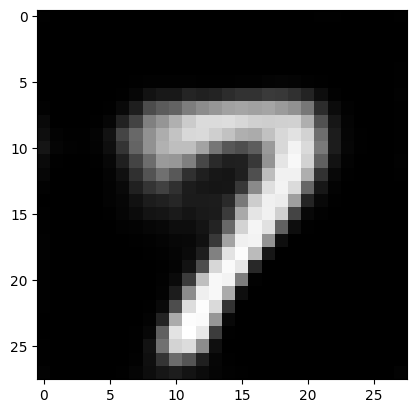

In [17]:
recon = vae.decoder(sample_tensor) 
plt.imshow(recon[0], cmap = 'gray')
plt.show()

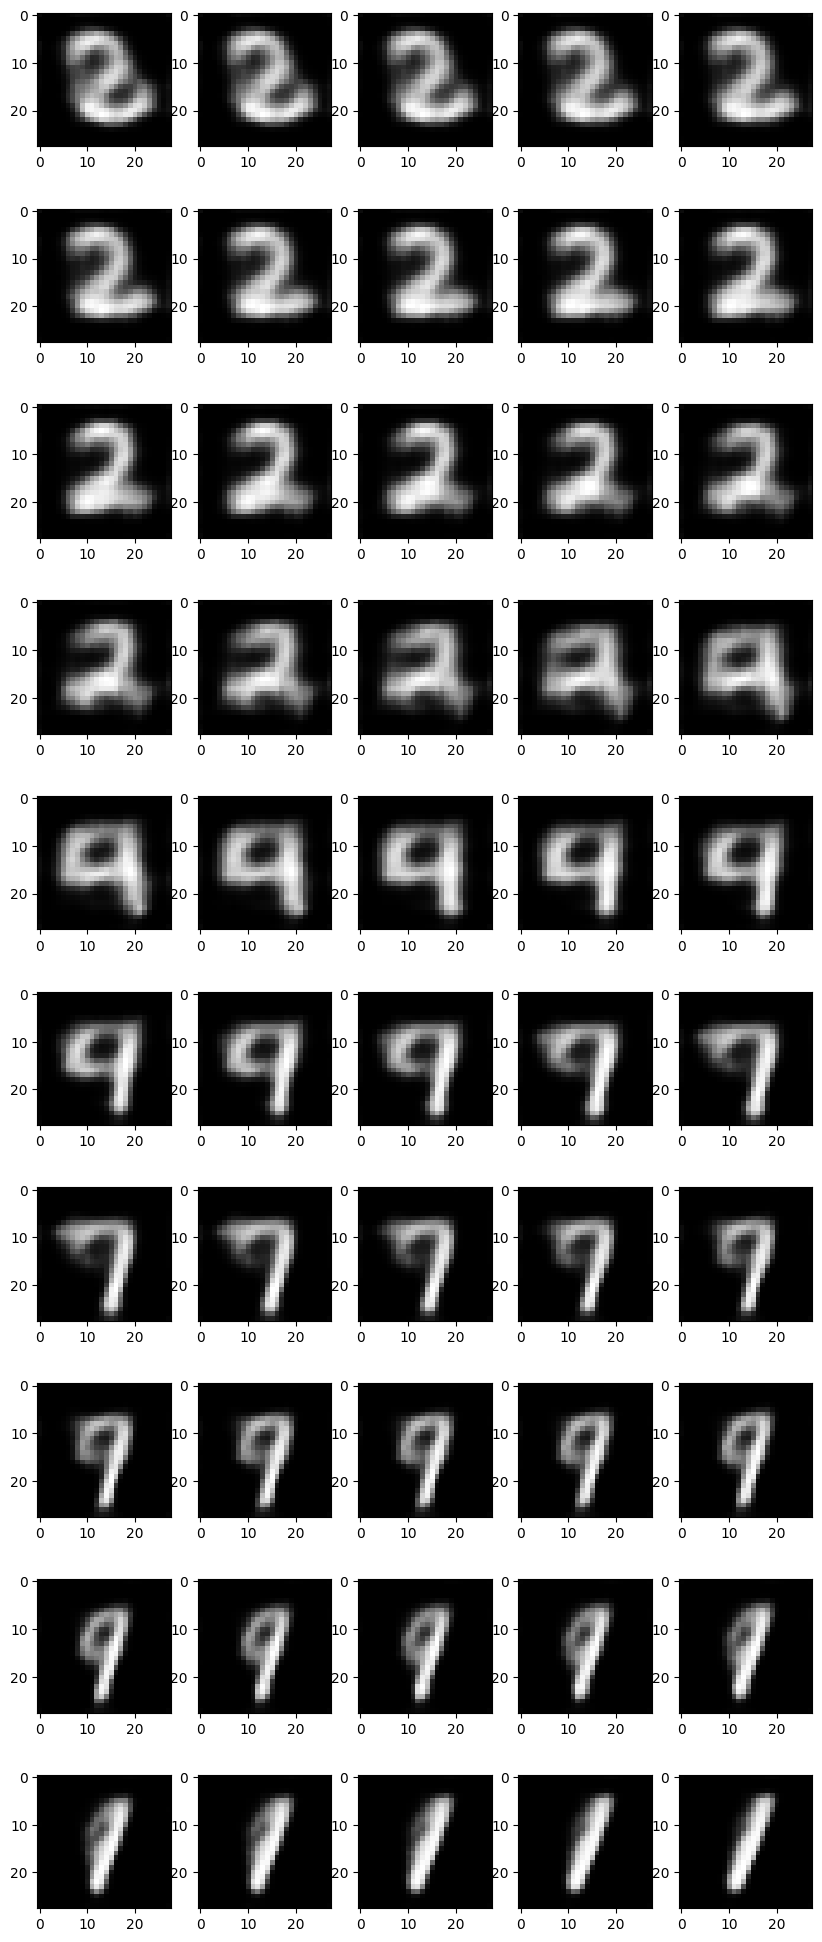

In [18]:
sample_list = []
for i in range(latent_dim):
    sample_list.append(np.expand_dims(np.linspace(-1, 1, 50), 0))

sample_pt = np.concatenate(sample_list, axis=0).T
recon = vae.decoder(sample_pt) 

n_rows = 5
fig, ax = plt.subplots(nrows = len(recon)//n_rows, ncols = n_rows, figsize = (10, 25))
for idx, img in enumerate(recon): 
    ax[idx//n_rows, idx%n_rows].imshow(img, cmap = 'gray')
plt.show()

15it [00:13,  1.13it/s]


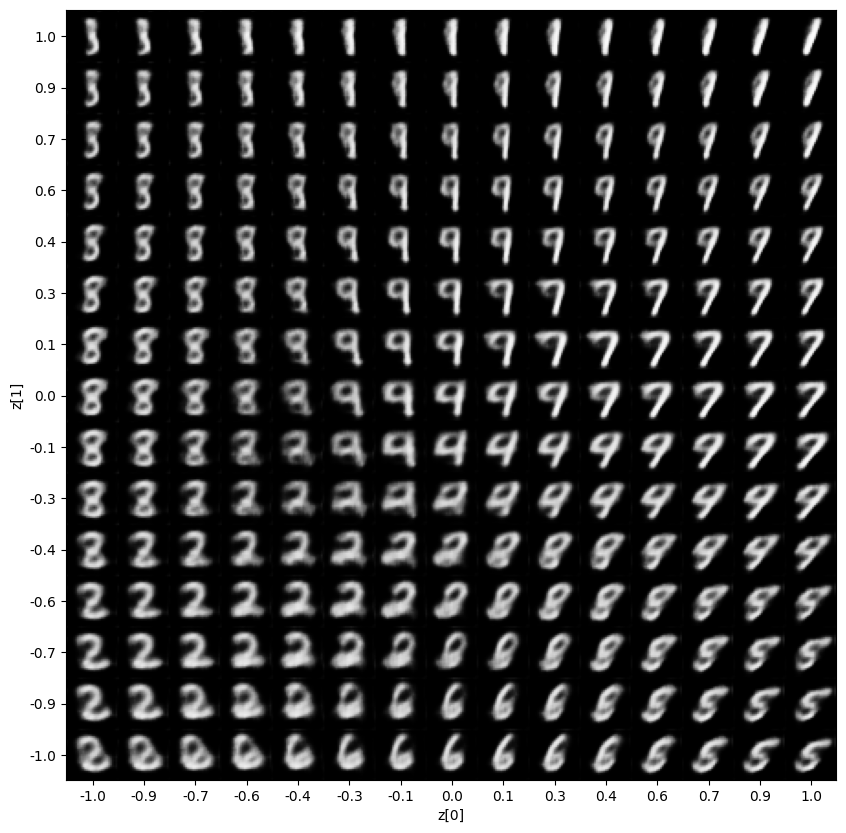

In [19]:
import matplotlib.pyplot as plt
from tqdm import tqdm

def plot_latent_space(model, n=15, figsize=10):
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in tqdm(enumerate(grid_y)):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = model.decoder.predict(z_sample, verbose=0)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

plot_latent_space(vae)